<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
<div hidden>
    $$
    \newcommand{\reals}{\mathbb{R}}
    \newcommand{\naturals}{\mathbb{N}}
    \newcommand{\integers}{\mathbb{Z}}
    \newcommand{\prob}{\mathbb{P}}
    \newcommand{\expect}{\mathbb{E}}
    \newcommand{\b}[1]{\mathbf{#1}}
    \newcommand{\bs}[1]{\boldsymbol{#1}}
    \newcommand{\c}[1]{\mathcal{#1}}
    \newcommand{mat}[2]{\left[\,\begin{array}{#1}#2\end{array}\,\right]}
    $$
</div>

# COMPSCI 371 Homework 1

_**Group Members:**_ Jose Pablo Rivera, Phillip Sievers, Gordon Liang

### Problem 0 (3 points)

## Part 1: Regression

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil
import pickle

In [2]:
def retrieve(file_name, semester='fall25', homework=1):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [3]:
points_file_name = 'points.pkl'
retrieve(points_file_name)
with open(points_file_name, 'rb') as file:
    points = pickle.load(file)

Using previously downloaded file points.pkl


In [26]:
import numpy as np

### Problem 1.1 (8 points)

In [5]:
x,y = points['x'], points['y']
n = len(x)

In [6]:
def fit_line(x, y):
    x_sum = 0
    y_sum = 0
    n = len(x)
    for i in range(n):
        x_sum += x[i]
        y_sum+= y[i]
    m_x= 1/n * x_sum
    m_y= 1/n * y_sum

    add_top= 0
    add_bottom= 0
    for i in range (n):
        add_top += (x[i]- m_x) * (y[i]- m_y)
    for i in range (n):
        add_bottom += (x[i]- m_x)**2
    b = (add_top)/ (add_bottom)
    a = m_y - b*(m_x)
    return (a,b)

a,b = fit_line(x,y)
print(a,b)

1.1935559626768808 1.3591251006679783


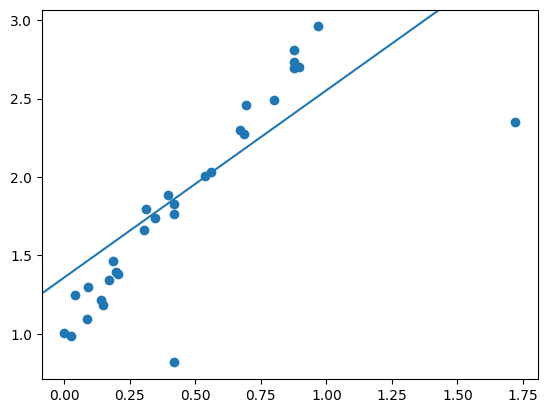

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(x,y)
plt.axline((0,b), slope=a)
plt.show()

### Problem 1.2

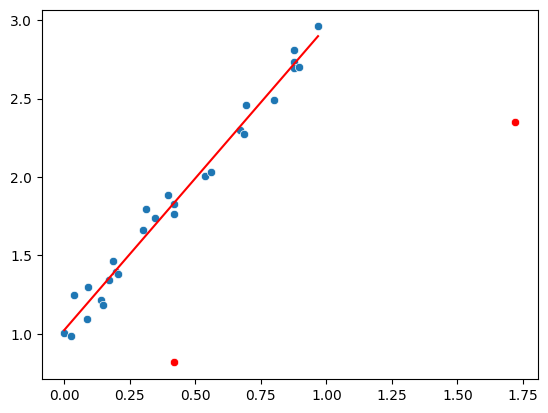

In [8]:
import seaborn as sb

def l(y, y_pred):
    return (y - y_pred)**2

residuals = []
for x, y in zip(points['x'], points['y']):
    y_pred = a + b * x
    residual = l(y, y_pred)
    residuals.append((residual, (x, y)))

residuals.sort(reverse=True, key=lambda tup: tup[0])

outliers = residuals[:2]
outlier_points = [item[1] for item in outliers]

x_clean = []
y_clean = []
for x, y in zip(points['x'], points['y']):
    if (x, y) not in outlier_points:
        x_clean.append(x)
        y_clean.append(y)

a_clean, b_clean = fit_line(x_clean, y_clean)

sb.scatterplot(x=x_clean, y=y_clean)
plot_array = np.array(outlier_points).T
sb.scatterplot(x=plot_array[0], y=plot_array[1], color='red')
x_range = np.linspace(min(x_clean), max(x_clean), 100)
y_values = a_clean + b_clean * x_range
plt.plot(x_range, y_values, color='red')

### Problem 1.3 (Exam Style)

The above method assumes that precisely two outliers exist. This cannot be used in general because fewer outliers would mean removal of valid data, whereas more outliers would fail to clean the data.

You would need to decide what you consider an outlier, whether it is an absolute or relative condition, and then see how many points follow said condition. Removing the two points with greatest residual loss does not account for the nuance of the number and condition of outliers.

### Problem 1.4

In [9]:
a_range = np.linspace(0.8, 1.2, 10)
b_range = np.linspace(1.5, 2.5, 10)

def loss(y_val, y_pred): 
    return abs(y_val - y_pred)

def risk(a, b, x_vals, y_vals):
    y_preds = a + b * x_vals
    return sum([loss(y, y_pred) for y, y_pred in zip(y_vals, y_preds)]) / len(y_vals)

min_risk = float('inf')
best_a = None
best_b = None
for a in a_range:
    for b in b_range:
        r = risk(a, b, points['x'], points['y'])
        if r < min_risk:
            min_risk = r
            best_a = a
            best_b = b

print(f'Minimal risk {min_risk} for a={best_a}, b={best_b}')

Minimal risk 0.16251082134162473 for a=1.0666666666666667, b=1.8333333333333333


### Problem 1.5 (Exam Style, Except for Question 4)

1. 100
2. k^m
3. 100^100=(10^2)^100=10^200
4. 10^78 to 10^82
5. no

## Part 2: $k$-Nearest Neighbors Regressors in One Dimension 

### Problem 2.1 (Exam Style)

[0, 7.0, 10.0, 20]
[((0, 24.0), (7.0, 24.0)), ((7.0, 24.0), (10.0, 24.0)), ((10.0, 18.0), (20, 18.0))]


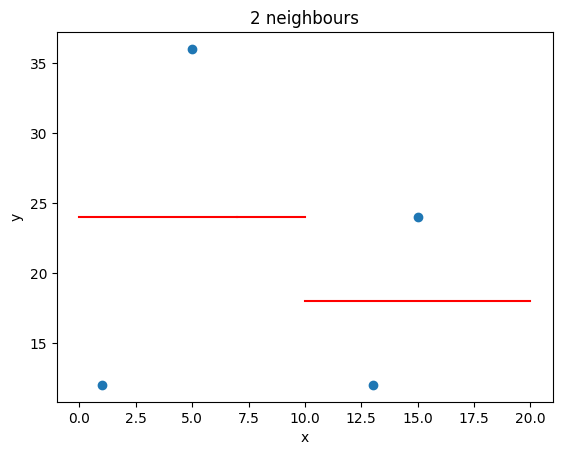

In [10]:
# x = np.array([2, 3, 5, 7, 11, 13, 17, 19])
# y = np.array([3, 1, 4, 1,  5,  9,  2,  6])

def nn(x, y, k):
    jumps = []
    jumps.append(0)
    for i in range(len(x) - k):
        jumps.append((x[i] + x[i+k]) / 2)
    jumps.append(20)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    
    points = []
    for i in range(len(x) - k + 1):
        m = sum(y[j] for j in range(i, i+k)) / k
        points.append(((jumps[i], m), (jumps[i+1], m)))
    for ((x1, y1), (x2, y2)) in points:
        plt.plot([x1, x2], [y1, y2], 'r-')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{k} neighbours")
    
    print(jumps)
    print(points)
    plt.show()

x = [1,  5,  13, 15]
y = [12, 36, 12, 24]

nn(x, y, 2)

### Problem 2.2 (Exam Style)

[0, 8.0, 20]
[((0, 20.0), (8.0, 20.0)), ((8.0, 24.0), (20, 24.0))]


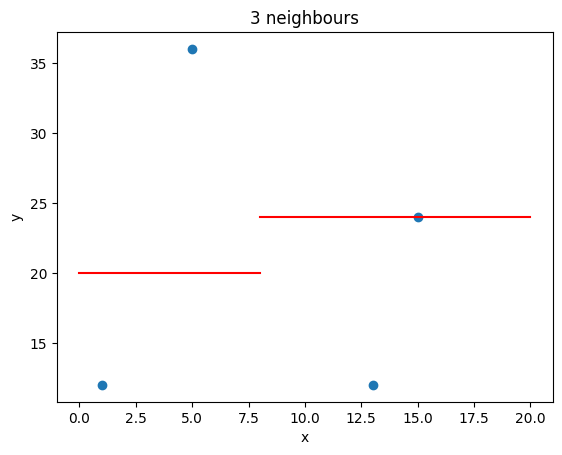

In [11]:
nn(x, y, 3)

### Problem 2.3 (Exam Style)

[0, 20]
[((0, 21.0), (20, 21.0))]


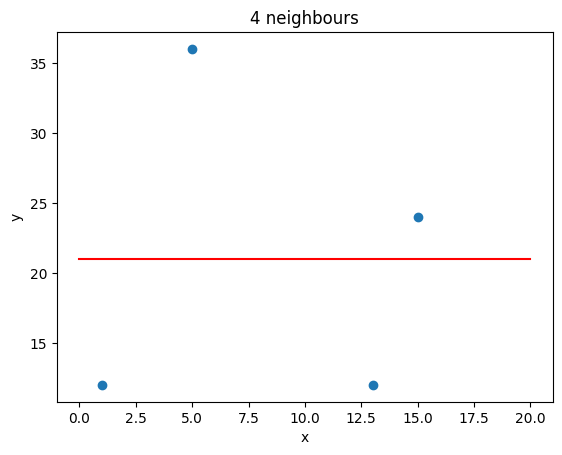

In [12]:
nn(x, y, 4)


## Part 3: Basics of Voronoi Diagrams in 2D

### Problem 3.1 (Exam Style)

We use point-slope form to find the bisector.
-1/slope is taken, since bisector slope is perpendicular to slope.

$$\text{slope} = \frac{b_2 - a_2}{\,b_1 - a_1\,}$$

$$\text{bisector slope} = -\frac{b_1 - a_1}{\,b_2 - a_2\,}$$

$$\text{midpoint} = \left(\tfrac{a_1+b_1}{2}, \tfrac{a_2+b_2}{2}\right),
\quad$$
$$m_x = \tfrac{a_1+b_1}{2},\; m_y = \tfrac{a_2+b_2}{2}$$

Equation of the perpendicular bisector:
$$y = -\frac{1}{\text{slope}}(x - m_x) + m_y$$
$$= -\frac{b_1 - a_1}{\,b_2 - a_2\,}\Bigl(x - \tfrac{a_1+b_1}{2}\Bigr) + \tfrac{a_2+b_2}{2}.$$

The bisector is a locus of points equidistant to a and b.
The midpoint between a,b is equidistant to a,b by definition.
Thus, the midpoint is on the bisector.

The bisector of 2 points in 3D is a PLANE.

/var/folders/x8/lr0srfxs7s1bp3k895t7djy80000gp/T/ipykernel_70024/2565049638.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


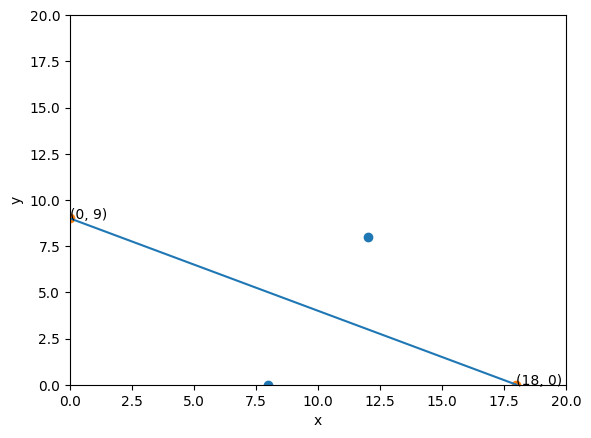

In [13]:
fig, ax = plt.subplots(1)

points = ((12,8),(8,0))
x = [x for (x,y) in points]
y = [y for (x,y) in points]

ax.scatter(x, y)
# ax.axline((12,0),(8,8))

# line between a, b:
# y = 2x - 16
# mp = (10, 4)
# bisector for a, b:
# y = -1/2*(x-10) + 4
#   = -x/2 + 9

intercepts = ((0, 9), (18, 0))

xint = (18, 0)
yint = (0, 9)
xs = [x for (x,y) in (xint, yint)]
ys = [y for (x,y) in (xint, yint)]
ax.scatter(xs, ys)
ax.text(xint[0], xint[1], "(18, 0)")
ax.text(yint[0], yint[1], "(0, 9)")
ax.axline(xint, yint)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

### Problem 3.2 (Exam Style)

a = (12, 8)
b = (8, 0)
c = (0, 0)

bisector(a,b): y = -1/2 x + 9

slope(a,c) = 8/12 = 2/3
-1/slope(a,c) = -1.5
midpoint(a,c) = (6, 4)

bisector(a,c): y= -1.5(x - 6) + 4 = -1.5x + 13
xint, yint = (8.667,0), (0, 13)

slope(b,c) = 0
-1/slope(b,c) = -1/0 -> vertical line
midpoint(b,c) = 4, 0

bisector(b,c): x = 4
xint = (4, 0)


PROOF
METHOD 1
$$d^2(x,a) = d^2(x,b)$$
$$d^2(x,a) = d^2(x,c)$$
therefore,
$$d^2(x,b) = d^2(x,c)$$
therefore,
the intersection of the bisectors of AB and AC lies on the bisector of BC
therefore, the bisectors of AB, AC, and BC intersect at a point.

METHOD 2
$$d^2(x,a) = d^2(x,b)$$
$$x^2 - 2a_1x + a_1^2 + y^2 - 2a_2y + a_2^2 = x^2 - 2b_1x + b_1^2 + + y^2 - 2b_2y + b_2^2$$

$$A = 2(b_1-a_1)$$
$$B = 2(b_2-a_2)$$
$$C = b_1^2 + b_2^2 - a_1^2 - a_2^2$$
$$D = 2(c_1-a_1)$$
$$E = 2(c_2-a_2)$$
$$F = c_1^2+c_2^2-a_1^2-a_2^2$$

$$Ax+By=C$$
$$Dx+Ey=F$$

$$AEx+BEy = CE$$
$$BDx+BEy = FB$$
$$(AE-BD)x = CE - FB$$
$$ x = \frac{CE - FB}{AE-BD} $$
$$ x = \frac{2(c_2-a_2)(b_1^2+b_2^2-a_1^2-a_2^2) - 2(b_2-a_2)(c_1^2+c_2^2-a_1^2-a_2^2)}{(2(b_1-a_1)\cdot 2(c_2-a_2) - 2(b_2-a_2)\cdot 2(c_1-a_1))} $$

numerator:

$$ 2(c_2-a_2)(b_1^2+b_2^2-a_1^2-a_2^2) - 2(b_2-a_2)(c_1^2+c_2^2-a_1^2-a_2^2) = 2(c_2-a_2)(b_1^2+b_2^2)-2(b_2-a_2)(c_1^2+c_2^2)-2(c_2-a_2)(a_1^2+a_2^2)+2(b_2-a_2)(a_1^2+a_2^2)$$

denominator:

$$ 4[(b_1-a_1)(c_2-a_2) - (b_2-a_2)(c_1-a_1) = 4(b_1c_2-b_1a_2-a_1c_2+a_1a_2-b_2c_1+b_2a_1+a_2c_1-a_2a_1) $$
$$ = 4(a_1(b_2-c_2)+b_1(c_2-a_2)+c_1(a_2-b_2)) $$

$$ x =\frac{(c_2-a_2)(b_1^2+b_2^2)-(b_2-a_2)(c_1^2+c_2^2)+(b_2-c_2)(a_1^2+a_2^2)}{2(a_1(b_2-c_2)+b_1(c_2-a_2)+c_1(a_2-b_2))} $$

/var/folders/x8/lr0srfxs7s1bp3k895t7djy80000gp/T/ipykernel_70024/3781276268.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


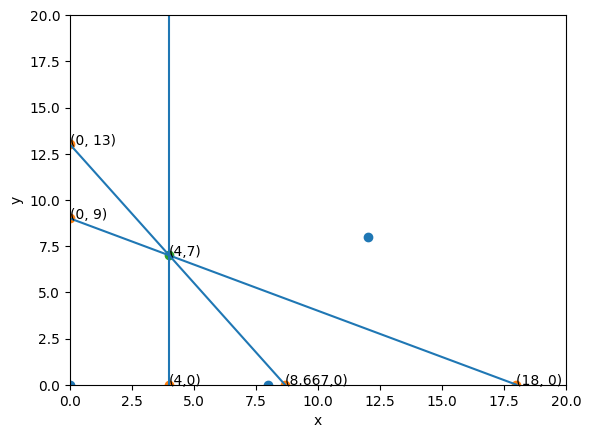

In [14]:
fig, ax = plt.subplots()

points = ((12,8),(8,0), (0,0))
x = [x for (x,y) in points]
y = [y for (x,y) in points]

ax.scatter(x, y)

intercepts = ((0, 9), (18, 0))

xints = ((18, 0), (8.667,0), (4,0))
yints = ((0, 9), (0, 13))
xs = [x for (x,y) in xints + yints]
ys = [y for (x,y) in xints + yints]
ax.scatter(xs, ys)
ax.scatter(4, 7)
ax.text(4, 7, "(4,7)")
ax.text(*xints[0], "(18, 0)")
ax.text(*yints[0], "(0, 9)")
ax.text(*xints[1], "(8.667,0)")
ax.text(*yints[1], "(0, 13)")
ax.text(*xints[2], "(4,0)")
ax.axline(xints[0], yints[0])
ax.axline(xints[1], yints[1])
ax.axline(xints[2], (4,1))

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

### Problem 3.3 (Exam Style)

/var/folders/x8/lr0srfxs7s1bp3k895t7djy80000gp/T/ipykernel_70024/100454465.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


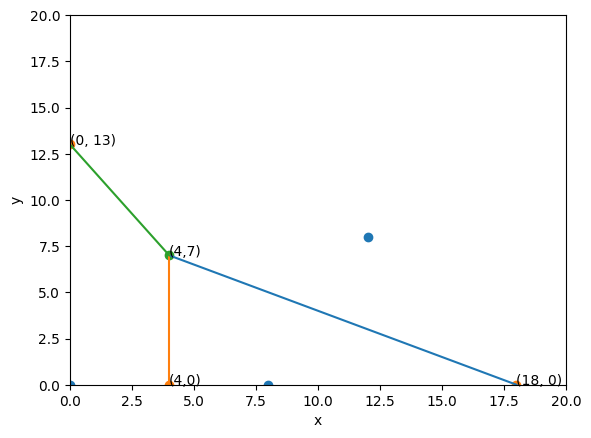

In [15]:
fig, ax = plt.subplots()

points = ((12,8),(8,0), (0,0))
x = [x for (x,y) in points]
y = [y for (x,y) in points]

ax.scatter(x, y)

intercepts = ((0, 9), (18, 0))
p = (4, 7)

xints = ((18, 0), (4,0))
yints = ((0, 13), )
xs = [x for (x,y) in xints + yints]
ys = [y for (x,y) in xints + yints]
ax.scatter(xs, ys)
ax.scatter(4, 7)
ax.text(4, 7, "(4,7)")
ax.text(*xints[0], "(18, 0)")
ax.text(*xints[1], "(4,0)")
ax.text(*yints[0], "(0, 13)")
plt.plot(*zip(xints[0], p))
plt.plot(*zip(xints[1], p))
plt.plot(*zip(p, yints[0]))

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.show()

## Part 4: Decision Regions of NN Classifiers in 2D

In [16]:
data_file_name = 'mnist_2d.pkl'
retrieve(data_file_name)
with open(data_file_name, 'rb') as file:
    data = pickle.load(file)

Using previously downloaded file mnist_2d.pkl


In [17]:
retrieve('helpers.py')

Using previously downloaded file helpers.py


In [18]:
from helpers import make_figure
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
xs, ys = data['train']['x'], data['train']['y']

### Problem 4.1 (warmup)

In [20]:
retrieve('helpers.py')
from helpers import ten_colors

Using previously downloaded file helpers.py


In [21]:
for dataset in ('train', 'test'):
    x_shape = data[dataset]['x'].shape
    print('{} {}ing data points in {} dimensions'.format(x_shape[0], dataset, x_shape[1]))
print('data domain', data['domain'])
labels = np.unique(data[dataset]['y'])
print('labels:', labels)

10000 training data points in 2 dimensions
60000 testing data points in 2 dimensions
data domain [-2.1, 2.3, -2.1, 2.3]
labels: [0 1 2 3 4 5 6 7 8 9]


In [22]:
xs, ys = data['train']['x'], data['train']['y']

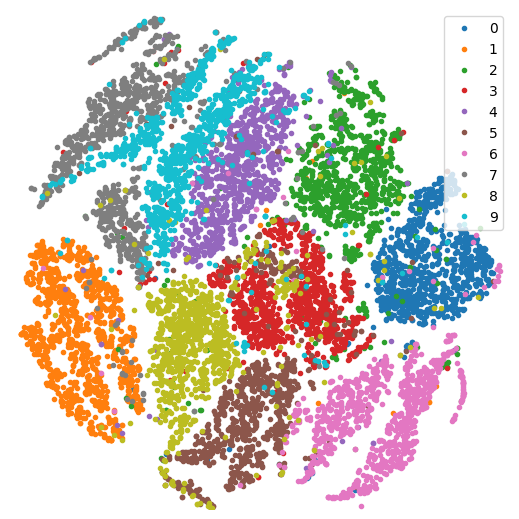

In [23]:
from helpers import make_figure
make_figure(data['domain'])
for digit in range(len(labels)):
    idx = ys == digit
    plt.plot(xs[idx, 0], xs[idx, 1], '.', label=str(digit))
plt.legend()
plt.show()

### Problem 4.1

In [24]:
import sklearn
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

k = 1
Training accuracy: 1.0
Testing accuracy: 0.902
Generalization: -0.098


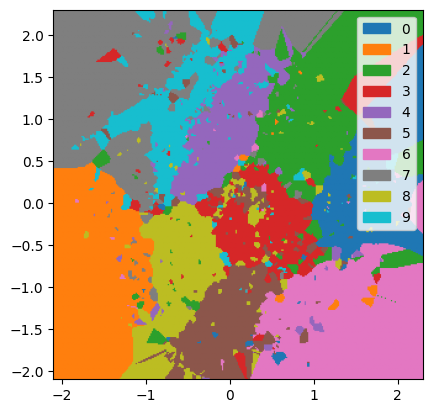

k = 4
Training accuracy: 0.943
Testing accuracy: 0.919
Generalization: -0.024


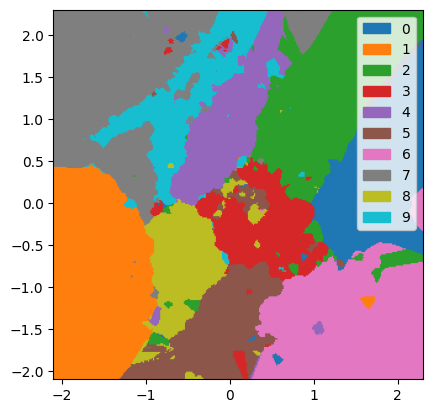

k = 8
Training accuracy: 0.933
Testing accuracy: 0.921
Generalization: -0.012


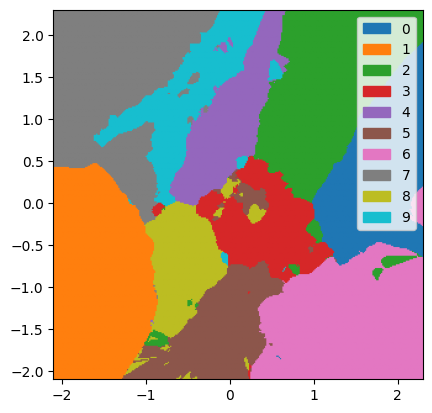

k = 16
Training accuracy: 0.924
Testing accuracy: 0.917
Generalization: -0.007


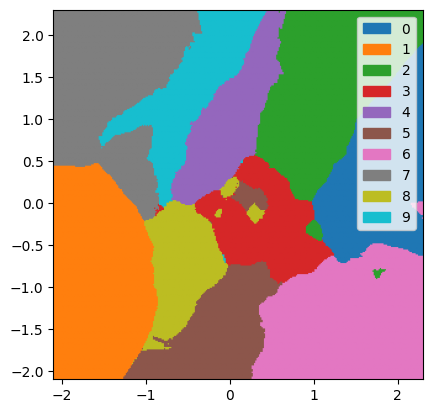

In [25]:
def decision_regions(h, box, g):
    x = np.linspace(box[0], box[1], g)
    y = np.linspace(box[2], box[3], g)
    X, Y = np.meshgrid(x, y)

    points = np.c_[X.ravel(), Y.ravel()]
    labels = h.predict(points)

    return np.reshape(labels, (g,g))

def show_regions(r, box, labels=None):
    values = np.unique(r)
    if not labels:
        labels = values
    ell = len(labels)

    plt.imshow(
        r, aspect=None, origin='lower', extent=box,
        vmin=min(values), vmax=max(values), 
        cmap=ListedColormap(ten_colors[:ell])
    )

    handles = [mpatches.Patch(color=ten_colors[j], label=labels[j]) for j in range(ell)]
    plt.legend(handles=handles)

def classify(k, d, g):
    train = d['train']
    test = d['test']
    train_x = train['x']
    train_y = train['y']
    test_x = test['x']
    test_y = test['y']
    h = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k)
    h.fit(train_x, train_y)
    training_accuracy = sklearn.metrics.accuracy_score(train_y, h.predict(train_x))
    testing_accuracy = sklearn.metrics.accuracy_score(test_y, h.predict(test_x))
    generalization = testing_accuracy - training_accuracy
    print(f'k = {k}')
    print(f'Training accuracy: {round(training_accuracy, 3)}')
    print(f'Testing accuracy: {round(testing_accuracy, 3)}')
    print(f'Generalization: {round(generalization, 3)}')
    r = decision_regions(h, d['domain'], g)
    show_regions(r, d['domain'])
    plt.show()

n_grid = 300
classify(1, data, n_grid)
classify(4, data, n_grid)
classify(8, data, n_grid)
classify(16, data, n_grid)

### Problem 4.2 (E                                                                                                                              xam Style)

1. no, training accuracy is always 1.0 for k = 1 NN 
every point in the input set is in the training set as well. 
for every point in the input set, its nearest neighbour is the point in the training set with the same coordinates.
since the input set equals the training set, the correct label equals its predicted label for every point in the input set.

2. k = 8
3. k = 16, generalization = -0.007
4. no, 
it goes up and down
k = 4, Testing accuracy: 0.919
k = 8, Testing accuracy: 0.921
k = 16, Testing accuracy: 0.917
5. yes,
it goes up and up
k = 1
Generalization: -0.098
k = 4
Generalization: -0.024
k = 8
Generalization: -0.012
k = 16
Generalization: -0.007
